In [ ]:
%%sql
{"code":"","namespace":"","database":"presto","tables":[],"outvar":""}

# Tutorial: Robust Linear regression

This tutorial demonstrates modeling and running inference on a robust linear regression model in Bean Machine. This should offer a simple modification from the standard regression model to incorporate heavy tailed error models that are more robust to outliers and demonstrates modifying base models.

## Problem
In this classical extension to the linear regression problem, the goal still is to estimate some unobserved response variable from an observed covariate. The twist from the basic linear regression model is that we now believe that errors can occasionally be large and we would like the model to be more robust to such error sources through an adequate observation model.
We'll construct a Bayesian model for this problem, which will yield not only point estimates but also measures of uncertainty in our predictions. We will also explore different inference procedures for this tutorial.


As in the linear regression tutorial (https://www.internalfb.com/intern/anp/view/?id=282519), we'll restrict this tutorial to the univariate case, to aid with clarity and visualization. We will follow the outline of the Stan tutorial in https://baezortega.github.io/2018/08/06/robust_regression/ for comparison.

Note: We recommend reading the linear regression tutorial before jumping into the robust regression tutorial.


## Prerequisites

Let's code this in Bean Machine! Import the Bean Machine library and some fundamental PyTorch classes.

In [1]:
# unittest
import os
import beanmachine.ppl as bm

import torch
from torch import tensor
import torch.distributions as dist
import matplotlib as mpl
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import sklearn
from sklearn import model_selection
import seaborn as sns

plt.rc('axes', xmargin=0, ymargin=0)
plt.rc('figure', figsize=[8, 6])
plt.rc('font', size=14)
plt.rc('hist', bins=30)
plt.rc('lines', linewidth=2.5)

pd.set_option('precision', 3)

torch.manual_seed(12);

smoke_test = ('SANDCASTLE_NEXUS' in os.environ or 'CI' in os.environ)


Bad key "axes.color_cycle" on line 214 in
/home/jpchen/.matplotlib/matplotlibrc.
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.1.2/matplotlibrc.template
or from the matplotlib source distribution


## Model

We're interested in predicting a reponse variable $y$ given an observed covariate $x$:

* $y = \beta x + \alpha + \text{error}$

If we assume the error to stem from a heavy-tailed distribution, for instance a Student's T, we can reframe this as:

* $y \sim \mathcal{T}(\beta x + \alpha, \sigma, \nu)$

Here, $\beta$ is a coefficient for $x$, $\alpha$ is a bias term, $\sigma$ is term indicating a deviation, and $\nu$ is a term describing degrees of freedom. Specifically:

* $N \in \mathbb{Z}^+$ is the size of the training data.
* $x_i \in \mathbb{R}$ is the observed covariate.
* $\beta \in \mathbb{R}$ is the coefficient for $x$. We'll use a prior of $\mathcal{N}(0,1000)$.
* $\alpha \in \mathbb{R}$ is the bias term. We'll use a prior of $\mathcal{N}(0,1000)$.
* $\sigma \in \mathbb{R}+$ is the error deviation. We'll use a Half-Normal prior $\text{HN}(0, 1000)$.
* $\nu \in \mathbb{R}+$ is the degrees of freedom of the StudentT. We'll use a Gamma prior $\text{G}(2,0.1)$.
* $y_i \stackrel{iid}{\sim} \mathcal{T}(\beta x_i + \alpha, \sigma, \nu) \in \mathbb{R}$ is the prediction.

We are interested in fitting posterior distributions for $\beta$, $\alpha$, $\sigma$, and $\nu$ given a collection of training data $\{x, y\}_{i=1}^N$.



<!-- Let's visualize the Gamma distribution that we used as our prior for $\epsilon$: -->

In [2]:
# epsilons = torch.arange(0.0, 2, 0.01)
# plt.plot(epsilons, dist.Gamma(1,1).log_prob(epsilons).exp())
# plt.xlabel("epsilon")
# plt.ylabel("density");

In [3]:
# Here we define the model components.
# Model is as described in https://baezortega.github.io/2018/08/06/robust_regression/

@bm.random_variable
def beta():
    """
    Regression Coefficient
    """
    return dist.Normal(0, 1000)


@bm.random_variable
def alpha():
    """
    Regression Bias/Offset
    """
    return dist.Normal(0, 1000)


@bm.random_variable
def sigma_regressor():
    """
    Deviation parameter for Student's T
    Controls the magnitude of the errors.
    """
    return dist.HalfNormal(1000)


@bm.random_variable
def df_nu():
    """
    Degrees of Freedom of a Student's T
    Check https://en.wikipedia.org/wiki/Student%27s_t-distribution for effect
    """
    return dist.Gamma(2, 0.1)

@bm.random_variable
def y_robust(X):
    """
    Heavy-Tailed Noise model for regression utilizing StudentT
    Student's T : https://en.wikipedia.org/wiki/Student%27s_t-distribution
    """
    return dist.StudentT(df=df_nu(), loc=beta() * X + alpha(), scale=sigma_regressor())

## Data

With the model defined, we need to collect some observed data in order to learn about values of interest in our model.

In this case, we will observe a few samples of inputs and outputs. For demonstrative purposes, we will use a synthetically generated dataset of observed values. In practice, you would gather a collection of covariate and response variables, and then you could construct a model to predict a new, unobserved response variable from a new, observed covariate.

For our synthetic dataset, we will assume the following parameters to the relationship between inputs and outputs.

In [4]:
#Todo: get this stuff to be like in the toy example.
sigma_data = torch.tensor([20,40])
rho = -0.95
N = 200

cov=torch.tensor([[torch.pow(sigma_data[0],2), sigma_data[0]*sigma_data[1]*rho],
[sigma_data[0]*sigma_data[1]*rho, torch.pow(sigma_data[1],2)]])

dist_clean=dist.MultivariateNormal(loc=torch.zeros(2), covariance_matrix=cov)
points = tensor([dist_clean.sample().tolist() for i in range(N)]).view(N, 2)
X = X_clean = points[:,0]
Y = Y_clean = points[:,1]

In [5]:
# N = 200

# X = dist.Normal(0, 1).expand([N, 1]).sample()
true_beta_1 = 2.
true_beta_0 = 5.
true_epsilon = 1.
# Y = dist.Normal(true_beta_1 * X + true_beta_0, true_epsilon).sample()

We can visualize the data as follows:

Text(0.5, 1.0, 'Clean Data')

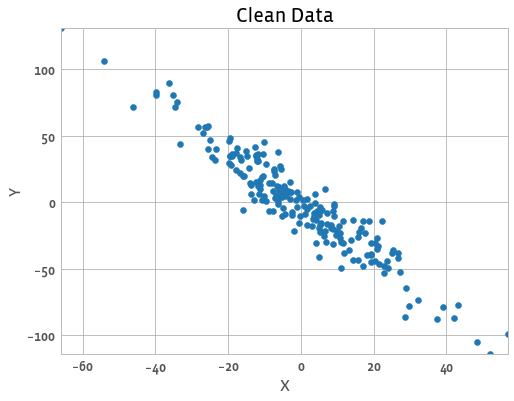

In [6]:
plt.scatter(X_clean, Y_clean);
plt.xlabel('X')
plt.ylabel('Y')
plt.title('Clean Data')

We will now corrupt this data with some extreme outliers.

In [7]:
points_noisy = points
points_noisy[0,:] = torch.tensor([-20, -80])
points_noisy[1,:] = torch.tensor([20, 100])
points_noisy[2,:] = torch.tensor([40, 40])
X_corr = points_noisy[:,0]
Y_corr = points_noisy[:,1]

Let's visualize the data now again after adding outliers.

Text(0.5, 1.0, 'Corrupted Data')

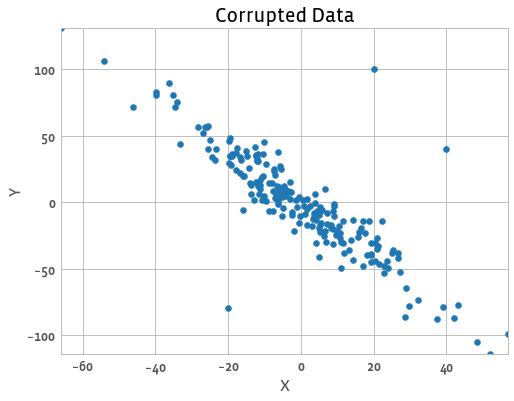

In [8]:
plt.scatter(X, Y);
plt.xlabel('X')
plt.ylabel('Y')
plt.title('Corrupted Data')

Let's split the dataset into a training and test set, which we'll use later to evaluate predictive performance.

In [9]:
X_train, X_test, Y_train, Y_test = sklearn.model_selection.train_test_split(X, Y)

Our inference algorithms expect observations in the form of a dictionary. This dictionary should consist of `@bm.random_variable` invocations as keys, and tensor data as values.

You can see this in the code snippet below, where we bind the observed values to a key representing the random variable that was observed.

In [10]:
observations = { y_robust(X_train): Y_train }

## Inference: Take 1

Inference is the process of combining _model_ with _data_ to obtain _insights_, in the form of probability distributions over values of interest. Bean Machine offers a powerful and general inference framework to enable fitting arbitrary models to data.

As a starting point for running inference, we will use the basic Metropolis-Hastings inference algorithm. Ancestral Metropolis-Hastings is a simple inference algorithm, which proposes child random variables conditional on values for the parent random variables. The most ancestral random variables are simply sampled from the prior distribution.

Running inference consists of a few arguments:

| Name | Usage
| --- | ---
| `queries` | A list of `@bm.random_variable` targets to fit posterior distributions for.
| `observations` | The `Dict` of observations we built up, above.
| `num_samples` | Number of samples to build up distributions for the values listed in `queries`.
| `num_chains` | Number of separate inference runs to use. Multiple chains can verify inference ran correctly.

Let's run inference:

In [11]:
num_samples = 1 if smoke_test else 2000

samples_mh = bm.GlobalNoUTurnSampler().infer(
    queries=[ beta(), alpha(), sigma_regressor(), df_nu() ],
    observations=observations,
    num_samples=num_samples,
    num_chains=2,
)

Samples collected:   0%|          | 0/2000 [00:00<?, ?it/s]

Samples collected:   0%|          | 0/2000 [00:00<?, ?it/s]

## Analysis: Take 1

`samples` now contains our inference results.

In [12]:
beta_marginal = samples_mh[ beta() ].flatten(start_dim=0, end_dim=1).detach()
alpha_marginal = samples_mh[ alpha() ].flatten(start_dim=0, end_dim=1).detach()
sigma_marginal = samples_mh[ sigma_regressor() ].flatten(start_dim=0, end_dim=1).detach()
nu_marginal = samples_mh[ df_nu() ].flatten(start_dim=0, end_dim=1).detach()

print(
    f"beta_marginal: {beta_marginal}\n"
    f"alpha_marginal: {alpha_marginal}\n"
    f"sigma_marginal: {sigma_marginal}\n"
    f"nu_marginal: {nu_marginal}"
)

beta_marginal: tensor([ 1.0962, -0.6266, -1.3122,  ..., -1.9042, -1.9577, -1.9623])
alpha_marginal: tensor([-1.0139, -0.8957, -0.9377,  ..., -1.4045, -1.4098, -0.8125])
sigma_marginal: tensor([ 3.1535, 10.3820, 13.8315,  ..., 10.5365, 11.3580, 10.2754])
nu_marginal: tensor([0.2072, 0.7932, 1.0649,  ..., 2.8776, 2.8507, 3.9226])


Next, let's visualize the inferred random variables.

In [13]:
def plot_marginal(
    variable_name,
    marginal_0,
    marginal_0_true_value=None,
    marginal_1=None,
    marginal_1_true_value=None,
):
    marginal_0 = marginal_0.squeeze()
    if len(marginal_0.shape) != 1:
        raise ValueError(
            f"Expected: marginal_0 has shape [:].\n"
            f"Actual: marginal_0 has shape {marginal_0.shape}."
        )
    
    if marginal_1 is None:
        plt.title(f"{variable_name} marginal")
        plt.hist(marginal_0, density=True)
        if marginal_0_true_value is not None:
            plt.axvline(x=marginal_0_true_value, label="True value", color="k")
        plt.axvline(x=marginal_0.mean(), label="Posterior mean", color="c")
        plt.xlabel(variable_name)
        plt.ylabel("density")
        plt.legend()
        
    else:
        marginal_1 = marginal_1.squeeze()
        if len(marginal_1.shape) != 1:
            raise ValueError(
                f"Expected: marginal_1 has shape [:].\n"
                f"Actual: marginal_1 has shape {marginal_1.shape}."
            )
        
        plt.suptitle(f"{variable_name} marginal", fontsize=20)
        
        grid = mpl.gridspec.GridSpec(4, 4)

        plt.subplot(grid[1:, :3])
        plt.hist2d(marginal_0.tolist(), marginal_1.tolist(), bins=60, density=True)
        if marginal_0_true_value is not None and marginal_1_true_value is not None:
            plt.plot(marginal_0_true_value, marginal_1_true_value, "wo", label="True value")
        plt.plot(marginal_0.mean(), marginal_1.mean(), "co", label="Posterior marginal mean")
        plt.xlabel(f"{variable_name}[0]")
        plt.ylabel(f"{variable_name}[1]")
        plt.legend()

        plt.subplot(grid[0, :3])
        plt.hist(marginal_0, density=True)
        if marginal_0_true_value is not None:
            plt.axvline(marginal_0_true_value, color="k")
        plt.axvline(marginal_0.mean(), color="c")
        plt.ylabel("density")
        plt.gca().axes.get_xaxis().set_ticklabels([])
        plt.margins(0)

        plt.subplot(grid[1:, 3])
        plt.hist(marginal_1, density=True, orientation="horizontal")
        if marginal_1_true_value is not None:
            plt.axhline(marginal_1_true_value, color="k")
        plt.axhline(marginal_1.mean(), color="c")
        plt.xlabel("density")
        plt.gca().axes.get_yaxis().set_ticklabels([])
        plt.margins(0)

    plt.show()

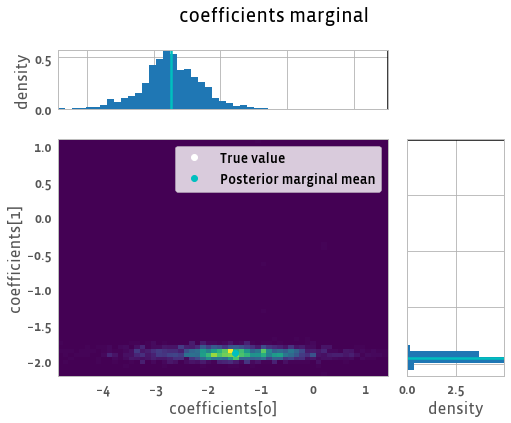

In [14]:
plot_marginal("coefficients", alpha_marginal, true_beta_0, beta_marginal, true_beta_1)

We seem to have faithfully recovered $\alpha$ but not $\beta$. It's possible that our prior was too strong relative to the small amount of data.

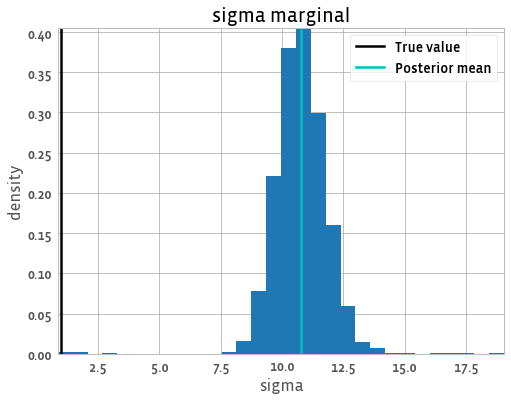

In [15]:
plot_marginal("sigma", sigma_marginal, true_epsilon)

We seem to have recovered a reasonably good understanding of the variance.

We can also compute log probability on the held-out test data. This isn't particularly useful on its own, but is useful for comparing different approaches. Thus, here, we will also plot a baseline for comparison: the log probability implied on the test dataset using the ground truth parameters.

In [82]:
# test_log_prob_mh = dist.Normal(
#     X_test @ beta_marginal[:2000].unsqueeze(0) + alpha_marginal[:2000].unsqueeze(0),
#     sigma_marginal[:2000],
# ).log_prob(Y_test).sum(dim=0)

# test_log_prob_ground_truth = dist.Normal(
#     X_test * true_beta_1 + true_beta_0,
#     true_epsilon,
# ).log_prob(Y_test).sum(dim=0).item()

# plt.title("Log probability on test data")
# plt.plot(test_log_prob_mh, label="MH")
# plt.axhline(test_log_prob_ground_truth, label=f"Ground truth = {test_log_prob_ground_truth:.2f}", color="k")
# plt.ylabel("Log probability")
# plt.legend();

In [16]:
bm.Diagnostics(samples_mh).summary()

,avg,std,2.5%,50%,97.5%,r_hat,n_eff
alpha()[],-1.484,0.873,-3.327,-1.509,0.263,1.011,167.008
beta()[],-1.893,0.084,-2.002,-1.895,-1.784,1.000,2168.200
df_nu()[],3.369,1.796,2.098,3.230,5.082,1.004,954.154
sigma_regressor()[],10.774,1.065,8.978,10.744,12.737,1.003,1243.536


The summary output shows two diagnostic statistics: [$\hat{R}$](https://projecteuclid.org/euclid.ss/1177011136) (`r_hat`) and [$N_\text{eff}$](https://www.mcmchandbook.net/HandbookChapter1.pdf) (effective sample size, `n_eff`).

  * $\hat{R} \in [1, \infty)$ summarizes how effective inference was at converging on the correct posterior distribution for a particular random variable. It uses information from all chains run in order to assess whether inference had a good understanding of the distribution or not. Values very close to zero indicate that all chains discovered similar distributions for a particular random variable. We do not recommend using inference results where $\hat{R} > 1.1$, as inference may not have converged. In that case, you may want to run inference for more samples.
  * $N_\text{eff} \in [1, \texttt{num}\_\texttt{samples}]$ summarizes how independent posterior samples are from one another. Although inference was run for `num_samples` iterations, it's possible that those samples were very similar to each other (due to the way inference is implemented), and may not each be representative of the full posterior space. Larger numbers are better here, and if your particular use case calls for a certain number of samples to be considered, you should ensure that $N_\text{eff}$ is at least that large.
  
In this case, both $\hat{R}$ and $N_\text{eff}$ leave something to be desired.

Bean Machine can also plot diagnostical information to assess model fit. Let's take a look:

In [17]:
bm.Diagnostics(samples_mh).plot(display=True);

The diagnostics output shows two diagnostic plots for individual random variables: trace plots and autocorrelation plots.

  * Trace plots are simply a time series of values assigned to random variables over each iteration of inference. The concrete values assigned are usually problem-specific. However, it's important that these values are "mixing" well over time. This means that they don't tend to get stuck in one region for large periods of time, and that each of the chains ends up exploring the same space as the other chains throughout the course of inference.
  * Autocorrelation plots measure how predictive the last several samples are of the current sample. Autocorrelation may vary between -1.0 (deterministically anticorrelated) and 1.0 (deterministically correlated). (We compute autocorrelation approximately, so it may sometimes exceed these bounds.) In an ideal world, the current sample is chosen independently of the previous samples: an autocorrelation of zero. This is not possible in practice, due to stochastic noise and the mechanics of how inference works.

From the trace plots, we see each of the chains are relatively healthy: they don't get stuck, and do not explore a chain-specific subset of the space. However, the trace plots are fairly "blocky", indicating that many traces are waste due to too low of an acceptance rate for new parameter values.

Let's see if we can do better by using another inference approach.

## Prediction

We've built and evaluated our model. Lastly, let's take a quick look at how to predict with it.

In [91]:
# def predict(x):
#     x = tensor(x).float()
#     return pd.DataFrame(
#         np.percentile(
#             dist.Normal(
#                 x.view([-1, 1]) @ beta_1_marginal.unsqueeze(0) + beta_0_marginal.unsqueeze(0),
#                 epsilon_marginal.unsqueeze(0),
#             ).sample([10]).transpose(0, 1).flatten(1),
#             [2.5, 50, 97.5],
#             axis=1,
#         ).T,
#         index=x.view(-1),
#         columns=['2.5%', '50%', '97.5%'],
#     )


Predict for a single value:

In [92]:
# predict(4)

Or for a range:

In [93]:
# predict(torch.linspace(-10, 10, 100)).plot()
# plt.scatter(X, Y, alpha=0.5);
